In [1]:
from data_withdiffusion import get_dataset_withdiffusion
train_loader, val_loader, test_loader = get_dataset_withdiffusion(MODEL_PATH = '/cap/RDDM-main/hsh/ECG2ECG_FINAL/LEAD1TO', DATA_PATH = '/cap/RDDM-main/datasets/', only_one=True)#, lead_num=[2,3,4,5,6,7,8,9,10,11,12])#, no_diffusion=True)

Deterministic with seed = 31


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1337/1337 [22:47<00:00,  1.02s/it]

----data setting with diffusion 완료----
torch.Size([21388])


### CNN model

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

class SignalClassifier1DCNN(nn.Module):
    def __init__(self, n_channels=12, num_classes=5):
        super(SignalClassifier1DCNN, self).__init__()
        
        # 첫 번째 컨볼루션 블록
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=n_channels, out_channels=32, kernel_size=7, stride=2, padding=3),
            nn.Dropout(0.2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        )
        
        # 두 번째 컨볼루션 블록
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.Dropout(0.2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        )
        
        # 세 번째 컨볼루션 블록
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.Dropout(0.2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        )
        
        # 네 번째 컨볼루션 블록
        # self.conv4 = nn.Sequential(
        #     nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
        #     nn.Dropout(0.2),
        #     nn.BatchNorm1d(256),
        #     nn.ReLU(),
        #     nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        # )
        
        # 적응형 풀링으로 출력 크기 고정
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)
        
        # 분류를 위한 완전 연결 레이어
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),  # 256 → 64 노드 감소
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        # 입력 형태: [batch_size, n_channels, signal_length]
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        #x = self.conv4(x)
        
        # 전역 평균 풀링
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)  # 평탄화
        
        # 분류
        x = self.classifier(x)
        return x


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

class ECG_CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 5), stride=1, padding=(1, 2)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((1, 2)),
            nn.Conv2d(32, 64, kernel_size=(3, 5), padding=(1, 2)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d((1, 10))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 1 * 10, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # (B, 1, 12, 1280)
        x = self.conv(x)
        return self.classifier(x)

In [4]:
# 학습 함수
import tqdm
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=10):
    best_val_loss = float('inf')
    best_model_weights = None
    early_stop_counter = 0
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # 학습 모드
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            # 입력 데이터 형태: [batch_size, n_channels, signal_length]
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels.to(torch.long))
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # 검증 모드
        model.eval()
        running_val_loss = 0.0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels.to(torch.long))
                running_val_loss += loss.item() * inputs.size(0)
        
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        # 학습률 조정
        scheduler.step(epoch_val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')
        
        # 최적 모델 저장 및 조기 종료 확인
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_weights = model.state_dict().copy()
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
    
    # 최적 모델 복원
    model.load_state_dict(best_model_weights)
    return model, train_losses, val_losses

# 평가 함수 (ROC, F1, Accuracy 계산)
def evaluate_model(model, test_loader, num_classes=5):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.to(torch.long).cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # 성능 지표 계산
    accuracy = accuracy_score(all_labels, all_preds)
    
    # 다중 클래스 F1 스코어 (macro 평균)
    f1 = f1_score(all_labels, all_preds, average='macro')
    
    # 다중 클래스 ROC AUC (one-vs-rest 방식)
    all_probs = np.array(all_probs)
    all_labels_one_hot = np.zeros((len(all_labels), num_classes))
    for i, label in enumerate(all_labels):
        all_labels_one_hot[i, label] = 1
    
    roc_auc = roc_auc_score(all_labels_one_hot, all_probs, multi_class='ovr')
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'F1 Score (Macro): {f1:.4f}')
    print(f'ROC AUC (OVR): {roc_auc:.4f}')
    
    return accuracy, f1, roc_auc


### 실행 코드

In [5]:
def run_experiment(n_channels=1, batch_size=16, learning_rate=0.001, num_epochs=50):
    # 모델 초기화
    model = ECG_CNN(num_classes=5)
    #n_channels=n_channels, 
    # 손실 함수 및 옵티마이저 설정
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    #scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    # 모델 학습
    trained_model, train_losses, val_losses = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=num_epochs
    )
    
    # 모델 평가
    accuracy, f1, roc_auc = evaluate_model(trained_model, test_loader)
    
    # 학습 곡선 시각화
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Learning Curves (n_channels={n_channels})')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'learning_curves_n{n_channels}.png')
    plt.show()
    
    return trained_model, accuracy, f1, roc_auc


Epoch 1/50, Train Loss: 1.2873, Val Loss: 1.1803
Epoch 2/50, Train Loss: 1.2026, Val Loss: 1.1754
Epoch 3/50, Train Loss: 1.1844, Val Loss: 1.1688
Epoch 4/50, Train Loss: 1.1760, Val Loss: 1.1665
Epoch 5/50, Train Loss: 1.1723, Val Loss: 1.1719
Epoch 6/50, Train Loss: 1.1625, Val Loss: 1.1509
Epoch 7/50, Train Loss: 1.1610, Val Loss: 1.1482
Epoch 8/50, Train Loss: 1.1558, Val Loss: 1.1451
Epoch 9/50, Train Loss: 1.1517, Val Loss: 1.1486
Epoch 10/50, Train Loss: 1.1501, Val Loss: 1.1593
Epoch 11/50, Train Loss: 1.1452, Val Loss: 1.1442
Epoch 12/50, Train Loss: 1.1381, Val Loss: 1.1354
Epoch 13/50, Train Loss: 1.1369, Val Loss: 1.1287
Epoch 14/50, Train Loss: 1.1357, Val Loss: 1.1371
Epoch 15/50, Train Loss: 1.1303, Val Loss: 1.1299
Epoch 16/50, Train Loss: 1.1292, Val Loss: 1.1280
Epoch 17/50, Train Loss: 1.1271, Val Loss: 1.1277
Epoch 18/50, Train Loss: 1.1258, Val Loss: 1.1401
Epoch 19/50, Train Loss: 1.1266, Val Loss: 1.1455
Epoch 20/50, Train Loss: 1.1197, Val Loss: 1.1523
Epoch 21/

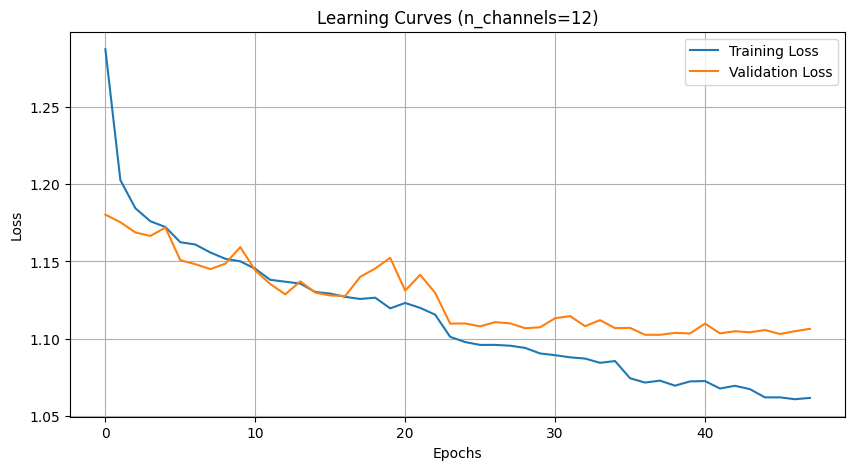

acc : 0.5985043234400561, f1 : 0.44932050146968283, roc_auc : 0.7932217247087618


In [6]:
model, accuracy, f1, roc_auc = run_experiment(n_channels=12)

print(f'acc : {accuracy}, f1 : {f1}, roc_auc : {roc_auc}')

In [7]:
for x, j in train_loader :
    print(x.shape, j.shape)
    break

torch.Size([16, 1, 1280]) torch.Size([16])


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from tqdm import tqdm
import random

def train(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    loop = tqdm(loader, desc="Training", leave=False)
    for x, y in loop:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y.long())
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        loop.set_postfix(loss=loss.item())
    return total_loss / len(loader.dataset)


# def evaluate(model, dataloader, criterion, device, num_classes):
#     model.eval()
#     running_loss = 0.0
#     all_preds = []
#     all_labels = []

#     with torch.no_grad():
#         for inputs, labels in dataloader:
#             inputs = inputs.to(device)
#             labels = labels.to(device)
#             outputs = model(inputs)
#             loss = criterion(outputs, labels.to(torch.long))
#             running_loss += loss.item()

#             preds = torch.argmax(outputs, dim=1)
#             true_labels = labels  # one-hot → label index

#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(true_labels.cpu().numpy())

#     # ⬇️ 클래스별 정확도 / F1-score 계산
#     report = classification_report(
#         all_labels, all_preds,
#         digits=4,
#         output_dict=False  # True로 하면 dict 형태, False는 텍스트 출력
#     )
#     print("📊 Classification Report:\n", report)

#     return running_loss / len(dataloader)

def evaluate(model, loader, criterion, device, phase="Eval"):
    model.eval()
    total_loss = 0
    preds_all, targets_all = [], []
    probs_all = []
    loop = tqdm(loader, desc=phase, leave=False)
    with torch.no_grad():
        for x, y in loop:
            x, y = x.to(device), y.to(device)
            output = model(x)  # logits
            loss = criterion(output, y.long())
            total_loss += loss.item() * x.size(0)
            preds_all.append(output.cpu())
            targets_all.append(y.cpu())
            probs_all.append(torch.softmax(output, dim=1).cpu())
            loop.set_postfix(loss=loss.item())
    preds = torch.cat(preds_all).argmax(dim=1)
    targets = torch.cat(targets_all)
    probs = torch.cat(probs_all)
    
    acc = accuracy_score(targets, preds)
    f1 = f1_score(targets, preds, average='macro')
    
    try:
        auc = roc_auc_score(torch.cat(targets_all), probs, multi_class='ovr')
    except ValueError:
        auc = float('nan')  # 클래스가 하나만 나왔을 경우 등
    
    return total_loss / len(loader.dataset), acc, f1, auc

def load_ecg_leads(prefix, type, num_leads=12, window_size = 10):
        leads = []
        for i in range(1, num_leads + 1):
            lead = np.load(f"{prefix}lead{i}_{type}.npy")  # e.g., lead1_train.npy
            lead = lead.reshape(-1, window_size * 128)
            leads.append(lead)
        return np.stack(leads, axis=1)  # shape: (N, 12, 1280)

class EarlyStopping:
    def __init__(self, patience=5, verbose=True, delta=0.0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_state = model.state_dict()
            if self.verbose:
                print(f"Validation loss improved. Resetting counter.")
        else:
            self.counter += 1
            if self.verbose:
                print(f"No improvement. Patience {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # GPU용 시드

    # CuDNN 관련 설정 (완전한 재현성 위해)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# 4. 실행
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 데이터 로드
    # path = "./single_label/"
    # x_train = load_ecg_leads(path, "train")
    # x_test = load_ecg_leads(path, "test")
    # y_train = np.load(path + "y_train.npy")
    # y_test = np.load(path + "y_test.npy")
    # num_classes = y_train.shape[1]

    # Dataset 구성
    # full_train = ECGDataset(x_train, y_train)
    # val_size = int(0.2 * len(full_train))
    # train_size = len(full_train) - val_size
    # train_dataset, val_dataset = random_split(full_train, [train_size, val_size])
    # test_dataset = ECGDataset(x_test, y_test)
    # g = torch.Generator()
    # g.manual_seed(42)
    # batch_size = 128
    # train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=g)
    # val_loader = DataLoader(val_dataset, batch_size=batch_size)
    # test_loader = DataLoader(test_dataset, batch_size=batch_size)

    
    criterion = nn.CrossEntropyLoss()


    # 모델, 손실함수, 옵티마이저
    model = ECG_CNN(num_classes=5).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # TensorBoard
    writer = SummaryWriter(log_dir="runs/exp4")

    early_stopper = EarlyStopping(patience=7)

    # 학습 루프
    for epoch in range(1, 51):
        train_loss = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_f1, val_auc = evaluate(model, val_loader, criterion, device, phase='Val')
        early_stopper(val_loss, model)
        print(f"[Epoch {epoch}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f} | AUC: {val_auc:.4f}")
        writer.add_scalar("AUC/val", val_auc, epoch)
        writer.add_scalar("Loss/train", train_loss, epoch)
        writer.add_scalar("Loss/val", val_loss, epoch)
        writer.add_scalar("Accuracy/val", val_acc, epoch)
        writer.add_scalar("F1/val", val_f1, epoch)
        if early_stopper.early_stop:
            print("Early stopping triggered.")
            break
    
    torch.save(early_stopper.best_model_state, 'best_model.pt')
    # # 테스트 평가
    model.load_state_dict(early_stopper.best_model_state)
    # 나중에 불러오기 (inference 시점)
    
    model = ECG_CNN(num_classes=5).to(device)
    model.load_state_dict(torch.load('best_model.pt'))
    test_loss, test_acc, test_f1, test_auc = evaluate(model, test_loader, criterion, device)
    print(f"\n[TEST] Loss: {test_loss:.4f} | Acc: {test_acc:.4f} | F1: {test_f1:.4f} | AUC: {test_auc:.4f}")


    # writer.close()


if __name__ == "__main__":
    main()

Validation loss improved. Resetting counter.
[Epoch 1] Train Loss: 1.2631 | Val Loss: 1.1971 | Acc: 0.5279 | F1: 0.3165 | AUC: 0.7490


Validation loss improved. Resetting counter.
[Epoch 2] Train Loss: 1.1730 | Val Loss: 1.1687 | Acc: 0.5445 | F1: 0.3676 | AUC: 0.7560


Validation loss improved. Resetting counter.
[Epoch 3] Train Loss: 1.1518 | Val Loss: 1.1646 | Acc: 0.5483 | F1: 0.3856 | AUC: 0.7601


Validation loss improved. Resetting counter.
[Epoch 4] Train Loss: 1.1403 | Val Loss: 1.1644 | Acc: 0.5537 | F1: 0.3962 | AUC: 0.7631


Validation loss improved. Resetting counter.
[Epoch 5] Train Loss: 1.1349 | Val Loss: 1.1536 | Acc: 0.5539 | F1: 0.3973 | AUC: 0.7644


Validation loss improved. Resetting counter.
[Epoch 6] Train Loss: 1.1275 | Val Loss: 1.1419 | Acc: 0.5558 | F1: 0.3963 | AUC: 0.7674


No improvement. Patience 1/7
[Epoch 7] Train Loss: 1.1221 | Val Loss: 1.1454 | Acc: 0.5602 | F1: 0.4107 | AUC: 0.7666


Validation loss improved. Resetting counter.
[Epoch 8] Train Loss: 1.1187 | Val Loss: 1.1414 | Acc: 0.5611 | F1: 0.4113 | AUC: 0.7686


No improvement. Patience 1/7
[Epoch 9] Train Loss: 1.1162 | Val Loss: 1.1426 | Acc: 0.5614 | F1: 0.4069 | AUC: 0.7678


Validation loss improved. Resetting counter.
[Epoch 10] Train Loss: 1.1120 | Val Loss: 1.1277 | Acc: 0.5661 | F1: 0.4225 | AUC: 0.7714


No improvement. Patience 1/7
[Epoch 11] Train Loss: 1.1081 | Val Loss: 1.1291 | Acc: 0.5668 | F1: 0.4205 | AUC: 0.7714


Validation loss improved. Resetting counter.
[Epoch 12] Train Loss: 1.1060 | Val Loss: 1.1240 | Acc: 0.5646 | F1: 0.4201 | AUC: 0.7726


No improvement. Patience 1/7
[Epoch 13] Train Loss: 1.1020 | Val Loss: 1.1489 | Acc: 0.5558 | F1: 0.3914 | AUC: 0.7691


No improvement. Patience 2/7
[Epoch 14] Train Loss: 1.0993 | Val Loss: 1.1380 | Acc: 0.5579 | F1: 0.4081 | AUC: 0.7715


No improvement. Patience 3/7
[Epoch 15] Train Loss: 1.0972 | Val Loss: 1.1270 | Acc: 0.5611 | F1: 0.4149 | AUC: 0.7725


No improvement. Patience 4/7
[Epoch 16] Train Loss: 1.0950 | Val Loss: 1.1251 | Acc: 0.5670 | F1: 0.4214 | AUC: 0.7729


Validation loss improved. Resetting counter.
[Epoch 17] Train Loss: 1.0923 | Val Loss: 1.1156 | Acc: 0.5710 | F1: 0.4262 | AUC: 0.7758


No improvement. Patience 1/7
[Epoch 18] Train Loss: 1.0900 | Val Loss: 1.1173 | Acc: 0.5686 | F1: 0.4272 | AUC: 0.7766


No improvement. Patience 2/7
[Epoch 19] Train Loss: 1.0876 | Val Loss: 1.1200 | Acc: 0.5684 | F1: 0.4228 | AUC: 0.7755


No improvement. Patience 3/7
[Epoch 20] Train Loss: 1.0855 | Val Loss: 1.1331 | Acc: 0.5623 | F1: 0.4150 | AUC: 0.7727


No improvement. Patience 4/7
[Epoch 21] Train Loss: 1.0880 | Val Loss: 1.1169 | Acc: 0.5703 | F1: 0.4218 | AUC: 0.7755


Validation loss improved. Resetting counter.
[Epoch 22] Train Loss: 1.0834 | Val Loss: 1.1122 | Acc: 0.5705 | F1: 0.4284 | AUC: 0.7776


No improvement. Patience 1/7
[Epoch 23] Train Loss: 1.0804 | Val Loss: 1.1139 | Acc: 0.5679 | F1: 0.4293 | AUC: 0.7773


No improvement. Patience 2/7
[Epoch 24] Train Loss: 1.0758 | Val Loss: 1.1151 | Acc: 0.5726 | F1: 0.4334 | AUC: 0.7778


No improvement. Patience 3/7
[Epoch 25] Train Loss: 1.0800 | Val Loss: 1.1144 | Acc: 0.5696 | F1: 0.4291 | AUC: 0.7781


Validation loss improved. Resetting counter.
[Epoch 26] Train Loss: 1.0760 | Val Loss: 1.1079 | Acc: 0.5731 | F1: 0.4309 | AUC: 0.7793


No improvement. Patience 1/7
[Epoch 27] Train Loss: 1.0715 | Val Loss: 1.1082 | Acc: 0.5726 | F1: 0.4308 | AUC: 0.7789


No improvement. Patience 2/7
[Epoch 28] Train Loss: 1.0741 | Val Loss: 1.1143 | Acc: 0.5705 | F1: 0.4234 | AUC: 0.7789


No improvement. Patience 3/7
[Epoch 29] Train Loss: 1.0718 | Val Loss: 1.1176 | Acc: 0.5721 | F1: 0.4330 | AUC: 0.7783


No improvement. Patience 4/7
[Epoch 30] Train Loss: 1.0656 | Val Loss: 1.1156 | Acc: 0.5696 | F1: 0.4299 | AUC: 0.7786


Validation loss improved. Resetting counter.
[Epoch 31] Train Loss: 1.0673 | Val Loss: 1.1043 | Acc: 0.5749 | F1: 0.4341 | AUC: 0.7815


No improvement. Patience 1/7
[Epoch 32] Train Loss: 1.0641 | Val Loss: 1.1121 | Acc: 0.5703 | F1: 0.4310 | AUC: 0.7799


No improvement. Patience 2/7
[Epoch 33] Train Loss: 1.0631 | Val Loss: 1.1131 | Acc: 0.5731 | F1: 0.4322 | AUC: 0.7794


No improvement. Patience 3/7
[Epoch 34] Train Loss: 1.0633 | Val Loss: 1.1114 | Acc: 0.5677 | F1: 0.4270 | AUC: 0.7800


No improvement. Patience 4/7
[Epoch 35] Train Loss: 1.0616 | Val Loss: 1.1123 | Acc: 0.5721 | F1: 0.4312 | AUC: 0.7803


Validation loss improved. Resetting counter.
[Epoch 36] Train Loss: 1.0592 | Val Loss: 1.1042 | Acc: 0.5787 | F1: 0.4391 | AUC: 0.7812


No improvement. Patience 1/7
[Epoch 37] Train Loss: 1.0545 | Val Loss: 1.1062 | Acc: 0.5794 | F1: 0.4427 | AUC: 0.7818


No improvement. Patience 2/7
[Epoch 38] Train Loss: 1.0541 | Val Loss: 1.1127 | Acc: 0.5719 | F1: 0.4390 | AUC: 0.7808


No improvement. Patience 3/7
[Epoch 39] Train Loss: 1.0539 | Val Loss: 1.1066 | Acc: 0.5721 | F1: 0.4330 | AUC: 0.7810


No improvement. Patience 4/7
[Epoch 40] Train Loss: 1.0519 | Val Loss: 1.1074 | Acc: 0.5731 | F1: 0.4357 | AUC: 0.7816


No improvement. Patience 5/7
[Epoch 41] Train Loss: 1.0497 | Val Loss: 1.1077 | Acc: 0.5756 | F1: 0.4381 | AUC: 0.7806


No improvement. Patience 6/7
[Epoch 42] Train Loss: 1.0497 | Val Loss: 1.1099 | Acc: 0.5770 | F1: 0.4423 | AUC: 0.7812


No improvement. Patience 7/7
[Epoch 43] Train Loss: 1.0486 | Val Loss: 1.1085 | Acc: 0.5740 | F1: 0.4329 | AUC: 0.7810
Early stopping triggered.



[TEST] Loss: 1.0793 | Acc: 0.5917 | F1: 0.4538 | AUC: 0.7941
